# ALTEGRAD - Lab 2 : Graph Mining
## October 2023

Student : Simon Queric

In [1]:
import networkx as nx
from networkx.drawing.layout import bipartite_layout
import matplotlib.pyplot as plt
import numpy as np
from scipy.sparse.linalg import eigs
from scipy.sparse import diags, eye
from random import randint
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

## Part 1 : Analysing a Real-World Graph

In [2]:
##### Task 1 #####

file = "datasets/CA-HepTh.txt"

G = nx.read_edgelist(file) 

print("Number of nodes :", len(G.nodes))
print("Number of edges :", len(G.edges))

Number of nodes : 9877
Number of edges : 25998


In [3]:
#### Task 2 ####

cc = nx.connected_components(G)
cc = sorted(nx.connected_components(G), key=len, reverse=True)

print("Number of connected components :", len(cc))


largest_cc = nx.induced_subgraph(G, cc[0]) ## largest components of G

Number of connected components : 429


In [4]:
#### Task 3 ####

# Degree #
degree_sequence = [G.degree(node) for node in G.nodes()]

print("Statistics :")

print("Minimum degree :", np.min(degree_sequence))
print("Maximum degree :", np.max(degree_sequence))
print("Mean degree :", np.mean(degree_sequence))
print("Median degree :", np.median(degree_sequence))

Statistics :
Minimum degree : 1
Maximum degree : 65
Mean degree : 5.264351523742027
Median degree : 3.0


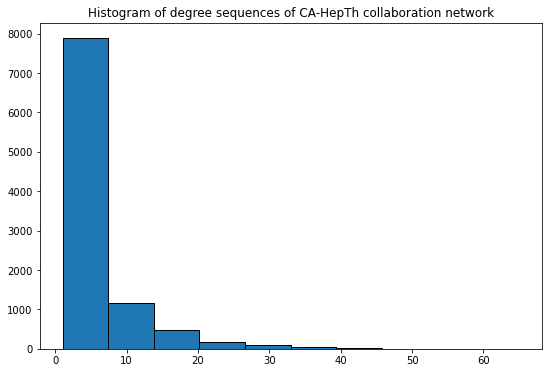

In [5]:
#### Task 4 ####

fig = plt.figure(figsize=(9, 6))
degree_hist = nx.degree_histogram(G)
plt.title("Histogram of degree sequences of CA-HepTh collaboration network")
plt.hist(degree_sequence, edgecolor="k")
plt.show()

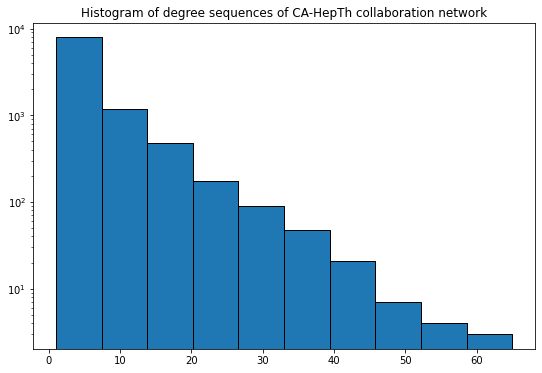

In [6]:
fig = plt.figure(figsize=(9, 6))
degree_hist = nx.degree_histogram(G)
plt.title("Histogram of degree sequences of CA-HepTh collaboration network")
plt.hist(degree_sequence, log=True, edgecolor="k")
plt.show()

In [9]:
#### Task 5 ####

clustering_coefficient = nx.transitivity(G)

print("Global Clustering coefficient og G : {:.4f}".format(clustering_coefficient))

Global Clustering coefficient og G : 0.2840


## Part 2 : Community Detection

In [10]:
#### Task 6 ####
# Perform spectral clustering to partition graph G into k clusters
def spectral_clustering(G, k):
    nodes = list(G.nodes)
    n = len(nodes)
    A = nx.to_numpy_array(G) # compute adjacency matrix
    d = A@np.ones(n)
    D = np.diag(1/d)
    M = np.dot(D, A)
    L = np.eye(n) - M # compute laplacian matrix
    eigvalues, U = np.linalg.eig(L)
    #plt.plot(np.sort(np.real(eigvalues)), 'x')
    indices = np.argsort(np.real(eigvalues))
    U = np.real(U)
    U = U[:, indices]
    kmeans = KMeans(n_clusters=k, n_init="auto").fit(U[:,:k])
    labels = kmeans.labels_
    clustering = {nodes[i] : labels[i] for i in range(n)}
    
    return clustering

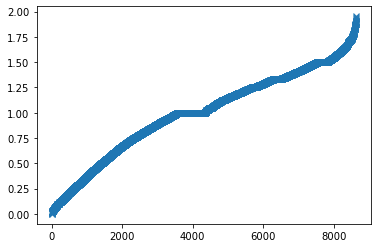

In [12]:
#### Task 7 ####

clustering = spectral_clustering(largest_cc, k=50)

In [48]:
#### Task 8 ####
# Compute modularity value from graph G based on clustering
def modularity(G, clustering):
    m = len(G.edges)
    cluster = np.array(list(clustering.values()))
    degree_seq = np.array([G.degree(node) for node in G.nodes()])
    k = max(clustering.values())+1 # number of clusters
    Q = 0
    for c in range(k) :
        nodes_c = [v for (v, i) in clustering.items() if i==c ]
        lc = len(nx.induced_subgraph(G, nodes_c).edges)
        #lc = len(G.subgraph(nodes_c).edges)
        dc = np.sum(degree_seq*(cluster==c)) 
        Q += lc/m - (dc/(2*m))**2
        
    return Q

In [49]:
#### Task 9 ####
m = len(largest_cc.edges)
n = len(largest_cc.nodes)
nodes = list(largest_cc.nodes)
random_clustering = [randint(0, 49) for _ in range(n)]
random_clustering = {nodes[i] : random_clustering[i] for i in range(n)}
print("Modularity of the Spectral Clustering : {:.4f}".format(modularity(largest_cc, clustering)))
print("Modularity of the random clustering : {:.4f}".format(modularity(largest_cc, random_clustering)))

Modularity of the Spectral Clustering : 0.1550
Modularity of the random clustering : 0.0001


The modularity of the random clustering is 0 while the modularity of the spectral clustering is 0.16. It shows that the spectral clustering succeed to detect community structures in the CA-HepTh collaboration network i.e groups of scientists that work together.

## Part 3 : Graph classification using Graph Kernels

In [66]:
#### Task 10 ####
# Generate simple dataset
def create_dataset():
    Gs = list()
    y = list()
    for n in range(3, 103):
        Gs.append(nx.cycle_graph(n))
        y.append(0) # The label of a cycle is 0
        Gs.append(nx.path_graph(n))
        y.append(1) # The label of a path is 1
        
    return Gs, y


Gs, y = create_dataset()
G_train, G_test, y_train, y_test = train_test_split(Gs, y, test_size=0.1)

# Compute the shortest path kernel
def shortest_path_kernel(Gs_train, Gs_test):    
    all_paths = dict()
    sp_counts_train = dict()
    
    for i,G in enumerate(Gs_train):
        sp_lengths = dict(nx.shortest_path_length(G))
        sp_counts_train[i] = dict()
        nodes = G.nodes()
        for v1 in nodes:
            for v2 in nodes:
                if v2 in sp_lengths[v1]:
                    length = sp_lengths[v1][v2]
                    if length in sp_counts_train[i]:
                        sp_counts_train[i][length] += 1
                    else:
                        sp_counts_train[i][length] = 1

                    if length not in all_paths:
                        all_paths[length] = len(all_paths)
                        
    sp_counts_test = dict()

    for i,G in enumerate(Gs_test):
        sp_lengths = dict(nx.shortest_path_length(G))
        sp_counts_test[i] = dict()
        nodes = G.nodes()
        for v1 in nodes:
            for v2 in nodes:
                if v2 in sp_lengths[v1]:
                    length = sp_lengths[v1][v2]
                    if length in sp_counts_test[i]:
                        sp_counts_test[i][length] += 1
                    else:
                        sp_counts_test[i][length] = 1

                    if length not in all_paths:
                        all_paths[length] = len(all_paths)

    phi_train = np.zeros((len(Gs_train), len(all_paths)))
    for i in range(len(Gs_train)):
        for length in sp_counts_train[i]:
            phi_train[i,all_paths[length]] = sp_counts_train[i][length]
    
  
    phi_test = np.zeros((len(Gs_test), len(all_paths)))
    for i in range(len(Gs_test)):
        for length in sp_counts_test[i]:
            phi_test[i,all_paths[length]] = sp_counts_test[i][length]

    K_train = np.dot(phi_train, phi_train.T)
    K_test = np.dot(phi_test, phi_train.T)

    return K_train, K_test

In [67]:
#### Task  ####
# Compute the graphlet kernel
def graphlet_kernel(Gs_train, Gs_test, n_samples=200):
    graphlets = [nx.Graph(), nx.Graph(), nx.Graph(), nx.Graph()]
    
    graphlets[0].add_nodes_from(range(3))

    graphlets[1].add_nodes_from(range(3))
    graphlets[1].add_edge(0,1)

    graphlets[2].add_nodes_from(range(3))
    graphlets[2].add_edge(0,1)
    graphlets[2].add_edge(1,2)

    graphlets[3].add_nodes_from(range(3))
    graphlets[3].add_edge(0,1)
    graphlets[3].add_edge(1,2)
    graphlets[3].add_edge(0,2)

    
    phi_train = np.zeros((len(G_train), 4))

    for i in range(len(Gs_train)) :
        G = Gs_train[i]
        for n in range(n_samples) :
            sample_graphlet = G.subgraph(np.random.choice(G.nodes, size=3, replace=False))
            if nx.is_isomorphic(sample_graphlet, graphlets[0]) :
                phi_train[i, 0]+=1
            if nx.is_isomorphic(sample_graphlet, graphlets[1]) :
                phi_train[i, 1]+=1
            if nx.is_isomorphic(sample_graphlet, graphlets[2]) :
                phi_train[i, 2]+=1
            if nx.is_isomorphic(sample_graphlet, graphlets[3]) :
                phi_train[i, 3]+=1

    phi_test = np.zeros((len(G_test), 4))
    
    for i in range(len(Gs_test)) :
        G = Gs_test[i]
        for n in range(n_samples) :
            sample_graphlet = G.subgraph(np.random.choice(G.nodes, size=3, replace=False))
            if nx.is_isomorphic(sample_graphlet, graphlets[0]) :
                phi_test[i, 0]+=1
            if nx.is_isomorphic(sample_graphlet, graphlets[1]) :
                phi_test[i, 1]+=1
            if nx.is_isomorphic(sample_graphlet, graphlets[2]) :
                phi_test[i, 2]+=1
            if nx.is_isomorphic(sample_graphlet, graphlets[3]) :
                phi_test[i, 3]+=1


    K_train = np.dot(phi_train, phi_train.T)
    K_test = np.dot(phi_test, phi_train.T)

    return K_train, K_test


K_train_sp, K_test_sp = shortest_path_kernel(G_train, G_test)

In [68]:
#### Task 12 ####

K_train_g, K_test_g = graphlet_kernel(G_train, G_test)

In [69]:
#### Task 13 ####

# Intialize SVM and train
clf_sp = SVC(kernel="precomputed")
clf_sp.fit(K_train_sp, y_train)

clf_g = SVC(kernel="precomputed")
clf_g.fit(K_train_g, y_train)

# Predictions with the two different classifiers (shortest path kernel and graphlet kernel)

y_pred_sp = clf_sp.predict(K_test_sp)
y_pred_g = clf_sp.predict(K_test_g)

In [72]:
print("Accuracy of the shortest path method :", accuracy_score(y_pred_sp,  y_test))
print("Accuracy of the graphlet methode : ", accuracy_score(y_pred_g,  y_test))

Accuracy of the shortest path method : 0.95
Accuracy of the graphlet methode :  0.5


We can see that the KSP classifier is a good classifier with accuracy equal to 0.95, while the graphlet classifier is bad because it is not better than a random classifier with accuracy equal to 0.5. 

We can explain that.

First, cycle graphs and path graphs have a lot of graphlets $G_2, G_3$ and $G_4$ in common and none of these graphs has graphlet $G_1$.

On the other hand, the maximum length of shortest path on $C_n$ is $n/2$ while the maximum length of a shortest path in $P_n$ is $n$. In a cycle, shortest paths tend to be smaller than on a path. It means that shortest paths distinguish cycles from paths graphs. 

It explains why the shortest path classifier is better than the graphlet method.